I have used a tool called ogr2ogr to convert the original json

with uses coordinates with WGS84(EPSG:4326) to projection (EPSG:31983)

Commands: ogr2ogr -f "GeoJSON" -t_srs "EPSG:31983" sergipeEPSG31983.geojson sergipe.json 

Github of the original JSON: https://github.com/giuliano-macedo/geodata-br-states

EPSG:4326: https://epsg.io/4326

EPSG:31983: https://epsg.io/31983

Import the necessary library's

In [107]:
from itertools import chain
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from typing import Tuple
from integrationsMethods import (
    result_I_Simpson_with_y_list,
    result_I_trapezoid_with_y_list,
)
import math
from shapely.geometry import shape
import numpy as np

Extract the points from the geojson

In [ ]:
fileName = 'sergipeEPSG31983'
d = json.load(open(f"./{fileName}.geojson"))
points = d["features"][0]["geometry"]["coordinates"][0][0]

Generate the coordinates of Sergipe perimeter

In [ ]:
OFFSET_X_WEIGHT = 1.34e6
OFFSET_Y_WEIGHT = 8.82e6
WEIGHT = 1e4
x = [(point[0] - OFFSET_X_WEIGHT) / WEIGHT for point in points]
y = [(point[1] - OFFSET_Y_WEIGHT) / WEIGHT for point in points]

In [110]:
def is_point_in_rectangle(p, a, b, c, d):
    """
    Check if point p is inside rectangle defined by points a, b, c, d
    Points should be in clockwise or counter-clockwise order
    """

    def cross_product(p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p2[1]) - (p2[1] - p1[1]) * (p3[0] - p2[0])

    # Check if point is on the same side of all edges
    d1 = cross_product(a, b, p)
    d2 = cross_product(b, c, p)
    d3 = cross_product(c, d, p)
    d4 = cross_product(d, a, p)

    # Point is inside if all cross products have the same sign
    return (d1 >= 0 and d2 >= 0 and d3 >= 0 and d4 >= 0) or (
        d1 <= 0 and d2 <= 0 and d3 <= 0 and d4 <= 0
    )
    
if __name__ == '__main__':
    is_point_in_rectangle((2.5, 2), (0,0), (0, 5), (5, 5), (5, 0))

In [111]:
def round_value(value: float, multiple=10000) -> int:
    return math.floor(value / multiple) * multiple


def round_down_point_to_multiple(point: Tuple[float, float], multiple=10000):
    return (round_value(point[0], multiple), round_value(point[1], multiple))

# Test examples
if __name__ == "__main__":
    print(round_down_point_to_multiple((15000, -5000)))

(10000, -10000)


Square Locations in the perimeter

In [ ]:
def find_all_y_for_x(x_target, x_points, y_points):
    """
    Find all Y values where a vertical line at x_target intersects
    the polygon perimeter defined by x_points and y_points.

    Returns a list of Y values (can be multiple for a closed polygon).
    """
    y_intersections = []

    # Iterate through each line segment
    for i in range(len(x_points) - 1):
        x1, y1 = x_points[i], y_points[i]
        x2, y2 = x_points[i + 1], y_points[i + 1]

        # Check if the vertical line at x_target intersects this segment
        # The segment must span across x_target
        if (x1 <= x_target <= x2) or (x2 <= x_target <= x1):
            # Avoid division by zero for vertical segments
            if x2 - x1 == 0:
                if x1 == x_target:
                    y_intersections.append(y1)
                    y_intersections.append(y2)
            else:
                # Linear interpolation: y = y1 + (y2-y1)/(x2-x1) * (x_target-x1)
                t = (x_target - x1) / (x2 - x1)
                y_intersection = y1 + t * (y2 - y1)
                y_intersections.append(y_intersection)

    # Remove duplicates and sort
    y_intersections = reversed(sorted(list(set(y_intersections))))

    points = [(x_target, y) for y in y_intersections]

    return points


weight = 1000
start = -10 * weight
end = int(10.5 * weight)
step = int(.5 * weight)
x_interval = list(range(start, end, step))
all_y_in_x = [find_all_y_for_x(x_target / weight, x, y) for x_target in x_interval]
points_interval = list(chain(*all_y_in_x))
x_interval = [point[0] for point in points_interval]
y_interval = [point[1] for point in points_interval]
if __name__ == "__main__":
    weight = 1000
    start = -10 * weight
    end = int(10.5 * weight)
    step = int(.5 * weight)
    test = [x / weight for x in range(start, end, step)]
    # for y_ in all_y_in_x:
    #     if len(y_) not in test:
    #         print(len(y_))
    #         test.append(len(y_))
    # print(points_interval)

In [ ]:
def new_y(item: list[tuple[float, float]]):
    value = 0
    if len(item):
        for index in range(2, len(item) + 1, 2):
            top, bottom = item[index - 2 : index]
            distance = abs(top[1] - bottom[1])  # Corrigido: removido abs duplicado
            value += distance
    return value

new_ys = list(map(new_y, all_y_in_x))
print(result_I_Simpson_with_y_list(new_ys, .5))
print(result_I_trapezoid_with_y_list(new_ys, .5))

22101759014.37026
22220286607.631844


Graph Configuration

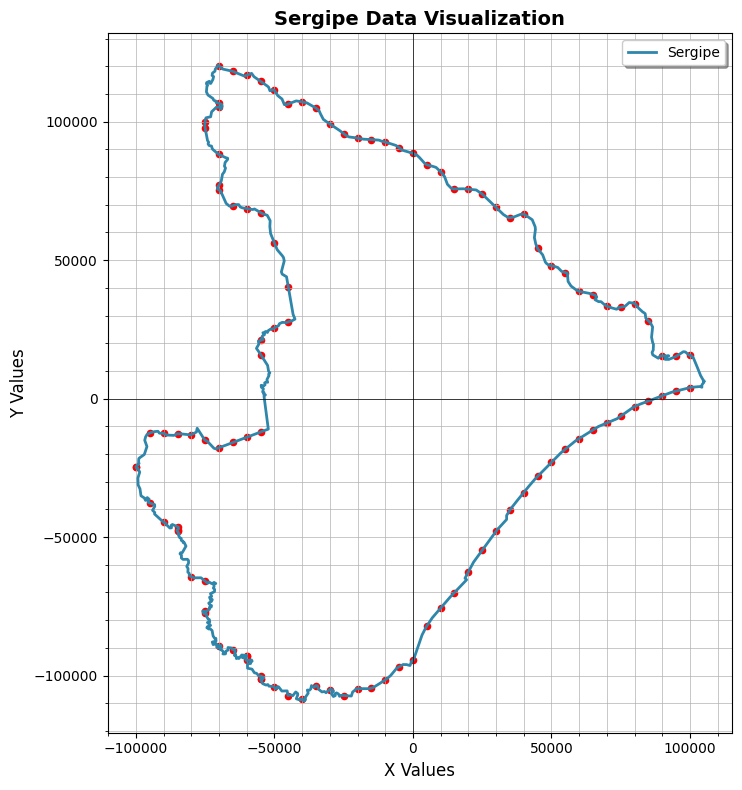

In [ ]:
# Create figure and axis with better size
fig, ax = plt.subplots(figsize=(10, 8))
line = ax.plot(x, y, linewidth=2, label="Sergipe", color="#2E86AB")
# Set up the grid with more divisions
ax.grid(True, which="both", linestyle="-", linewidth=0.7, alpha=0.7)
# Add minor grid lines for more divisions
ax.minorticks_on()
ax.grid(True, which="minor", linestyle="-", linewidth=0.7, alpha=0.7)
# Add axes at (0,0)
ax.axhline(y=0, color="k", linewidth=0.5)
ax.axvline(x=0, color="k", linewidth=0.5)
# # Major ticks every 50,000
# ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(1))
# # Minor ticks every 10,000
# ax.xaxis.set_minor_locator(MultipleLocator(.5))
# ax.yaxis.set_minor_locator(MultipleLocator(.5))
# Add labels and title
ax.set_xlabel("X Values", fontsize=12)
ax.set_ylabel("Y Values", fontsize=12)
ax.set_title("Sergipe Data Visualization", fontsize=14, fontweight="bold")
# Add legend
ax.legend(loc="best", frameon=True, fancybox=True, shadow=True)
# Improve tick formatting
ax.tick_params(axis="both", which="major", labelsize=10)
# Adjust layout to prevent clipping
plt.tight_layout()
ax.set_aspect(1)
# Add red points
ax.scatter(x_interval, y_interval, s=20, color='red')
# plot the graph
plt.show()